# Chapter 8. JAGS

* 베이지안 통계 R
* Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan
* 김무성

# Contents

* 8.1. JAGS and Its Relation to R
* 8.2. A Complete Example
* 8.3. Simplified Scripts for Frequently Used Analyses
* 8.4. Example: Difference of Biases
* 8.5. Sampling from the Prior Distribution in JAGS
* 8.6. Probability Distributions Available in JAGS
* 8.7. Faster Sampling with Parallel Processing in RunJAGS
* 8.8. Tips for Expanding JAGS Models

### 참고 : 설치 팁

#### Ubuntu 12.04 이상
1. sudo apt-get install jags ==> JAGS 3.4.0 설치됨
2. R (혹은 RStudio) 실행 > install.packages('rjags') ==> rjags 3-14 설치됨
3. R (혹은 RStudio) 실행 > install.packages('runjags')

#### Mac OS X 10.10.2 이상 (혹은 mavericks 이상 버전)

by 김주동님
1. https://martynplummer.wordpress.com/category/mac-os-x/ 에서 JAGS-Mavericks-3.4.0.dmg 설치! ==> JAGS 3.4.0 설치됨
2. R (혹은 RStudio) 실행 > install.packages('rjags') ==> rjags 3-14 설치됨
3. R (혹은 RStudio) 실행 > install.packages('runjags')

# 8.1. JAGS and Its Relation to R

<img src="figures/fig8.1.png" />

#### 참고

* bayesian inference ?

<img src="http://www.lancs.ac.uk/~jamest/Group/images/bayesthm.JPG" />

<img src="http://www.lanl.gov/bayesian/images/bayesPicture.jpg" width=600 />

<img src="http://raven.iab.alaska.edu/~ntakebay/teaching/programming/coalsim/posterior.png" />

* hierarchical model ?

<img src="http://www.nature.com/nbt/journal/v28/n4/images_article/nbt.1619-F1.gif" />

<img src="http://i.stack.imgur.com/ZerKf.png" />

* monte carlo simulation ?

<img src="http://upload.wikimedia.org/wikipedia/commons/8/84/Pi_30K.gif" />

<img src="http://adcats.et.byu.edu/Publication/91-1/pics/Image482.gif" />

* Markov Chain ? 

<img src='http://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/220px-Markovkate_01.svg.png' />

<img src="https://xakep.ru/wp-content/uploads/2015/04/0029.png" width=600 />

* MCMC ?

<img src="http://www.juergenwiki.de/work/wiki/lib/exe/fetch.php?w=500&tok=f4ed3e&media=public:murray_mlss2009talk_mcmc_21.png" width=600 />

* gibbs sampling ?

<img src="http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/ebooks/html/csa/img1321.gif" />

#  8.2. A Complete Example

* 8.2.1 Load data
* 8.2.2 Specify model
* 8.2.3 Initialize chains
* 8.2.4 Generate chains
* 8.2.5 Examine chains

### Bayesian estimation of the bias of a coin !

### 참고 

* bernoulli distribution ?

<img src="https://universe-review.ca/I15-30-StatBerno.png" />

* beta distribution ?

<img src="http://www.theanalysisofdata.com/probability/figs/irv12.png" />

<img src="figures/eq8.1.png" />

<img src="figures/eq8.2.png" />

<img src="figures/fig8.2.png" />

## 8.2.1 Load data

In [1]:
# Load the functions used below:
source("DBDA2E-utilities.R") # Must be in R's current working directory.
require(rjags)               # Must have previously installed package rjags.


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



Loading required package: coda
Loading required package: rjags
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


In [2]:
# Load the data:
myData = read.csv("z15N50.csv") # Read data file; must be in curr. work. dir.

In [3]:
head(myData)

  y
1 0
2 1
3 0
4 0
5 0
6 0

In [4]:
str(myData)

'data.frame':	50 obs. of  1 variable:
 $ y: int  0 1 0 0 0 0 0 0 0 0 ...


In [5]:
y = myData$y        # The y values are in the column named y.
Ntotal = length(y)  # Compute the total number of flips.
dataList = list(    # Put the information into a list.
  y = y ,
  Ntotal = Ntotal 
)

In [6]:
dataList

$y
 [1] 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0
[39] 0 1 0 0 1 1 0 1 0 0 0 0

$Ntotal
[1] 50


## 8.2.2 Specify model

In [ ]:
model {    
    for ( i in 1:Ntotal ) {
        y[i] ~ dbeta( theta)  # likelihood
    }
    theta ~ dbeta( 1, 1 ) # prior
}

To get the model specification into JAGS, we create the specification as a character string in R, then save the string to a temporary text file, and subsequently send the text file to JAGS.

In [8]:
# Define the model:
modelString = "
model {
  for ( i in 1:Ntotal ) {
    y[i] ~ dbern( theta )
  }
  theta ~ dbeta( 1 , 1 )
}
" # close quote for modelString
writeLines( modelString , con="TEMPmodel.txt" )

In [9]:
modelString

[1] "\nmodel {\n  for ( i in 1:Ntotal ) {\n    y[i] ~ dbern( theta )\n  }\n  theta ~ dbeta( 1 , 1 )\n}\n"

## 8.2.3 Initialize chains

* MLE ? - http://statgen.iop.kcl.ac.uk/bgim/mle/sslike_3.html

<img src="http://statgen.iop.kcl.ac.uk/media/ml1.gif" />

Bernoulli likelihood function => MLE => theta = z / N

In [ ]:
thetaInit = sum(y)/length(y)
initsList = list(theta=thetaInit)

start the chains at random points neart MLE

In [10]:
# Initialize the chains based on MLE of data.
# Option: Use single initial value for all chains:
#  thetaInit = sum(y)/length(y)
#  initsList = list( theta=thetaInit )
# Option: Use function that generates random values for each chain:
initsList = function() {
  resampledY = sample( y , replace=TRUE )
  thetaInit = sum(resampledY)/length(resampledY)
  thetaInit = 0.001+0.998*thetaInit # keep away from 0,1
  return( list( theta=thetaInit ) )
}

#### To demonstrate how the initsList function works !!

In [11]:
y = c(rep(0,25), rep(1, 75))

In [12]:
y

  [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [13]:
initsList()

$theta
[1] 0.72954


In [14]:
initsList()

$theta
[1] 0.78942


In [15]:
initsList()

$theta
[1] 0.80938


## 8.2.4 Generate chains

In [16]:
# Run the chains:
jagsModel = jags.model( file="TEMPmodel.txt" , data=dataList , 
                       inits=initsList , n.chains=3 , n.adapt=500 )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 53

Initializing model



In [17]:
# burn in 
update( jagsModel , n.iter=500 )

In [18]:
# generate MCMC samples
codaSamples = coda.samples( jagsModel , variable.names=c("theta") ,  n.iter=3334 )

In [67]:
3 * 3334

[1] 10002

In [19]:
head(codaSamples)

[[1]]
Markov Chain Monte Carlo (MCMC) output:
Start = 501 
End = 507 
Thinning interval = 1 
         theta
[1,] 0.3954430
[2,] 0.3641153
[3,] 0.2266503
[4,] 0.2759135
[5,] 0.2799393
[6,] 0.2562298
[7,] 0.2774688

[[2]]
Markov Chain Monte Carlo (MCMC) output:
Start = 501 
End = 507 
Thinning interval = 1 
         theta
[1,] 0.3793210
[2,] 0.2826473
[3,] 0.2844607
[4,] 0.4082888
[5,] 0.3565756
[6,] 0.2621498
[7,] 0.1781693

[[3]]
Markov Chain Monte Carlo (MCMC) output:
Start = 501 
End = 507 
Thinning interval = 1 
         theta
[1,] 0.2652788
[2,] 0.3797468
[3,] 0.3269976
[4,] 0.2423935
[5,] 0.3816946
[6,] 0.2782939
[7,] 0.1824442

attr(,"class")
[1] "mcmc.list"

In [20]:
str(codaSamples)

List of 3
 $ : mcmc [1:3334, 1] 0.395 0.364 0.227 0.276 0.28 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 501 3834 1
 $ : mcmc [1:3334, 1] 0.379 0.283 0.284 0.408 0.357 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 501 3834 1
 $ : mcmc [1:3334, 1] 0.265 0.38 0.327 0.242 0.382 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 501 3834 1
 - attr(*, "class")= chr "mcmc.list"


In [21]:
save( codaSamples , file="Mcmc.Rdata")

## 8.2.5 Examine chains

* 8.2.5.1 The plotPost function

<img src="figures/fig8.3.png" />

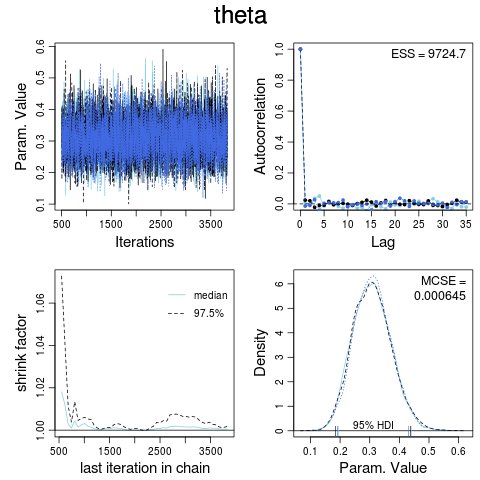

In [22]:
# Convergence diagnostics:
diagMCMC( codaObject=codaSamples , parName="theta" )

In [23]:
saveGraph( file="ThetaDiag", type="eps" )

pdf 
  2 

### 8.2.5.1 The plotPost function

<img src="figures/fig8.4.png" />

In [ ]:
# left figure
plotPost(codaSamples[,"theta"], main=thera, xlab=bquote(theta))

In [ ]:
# right figure
plotPost(codaSamples[,"theta"], main=thera, xlab=bquote(theta), 
        cenTend="median", compVal=0.5, ROPE=c(0.45, 0.55), credMass=0.90)

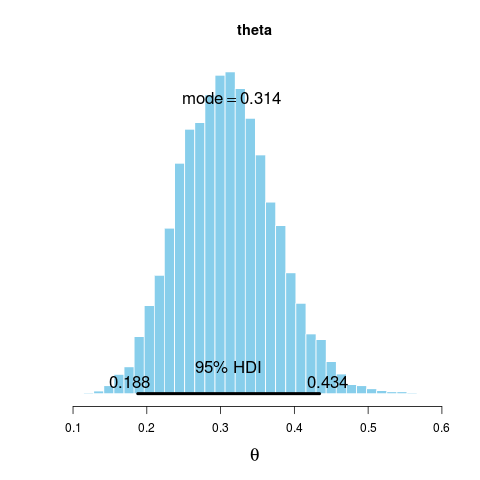

        ESS      mean    median      mode hdiMass    hdiLow   hdiHigh compVal
theta 10002 0.3087411 0.3070736 0.3143869    0.95 0.1876636 0.4342617      NA
      pGtCompVal ROPElow ROPEhigh pLtROPE pInROPE pGtROPE
theta         NA      NA       NA      NA      NA      NA

In [24]:
# Posterior descriptives:
plotPost( codaSamples[,"theta"] , main="theta" , xlab=bquote(theta) )

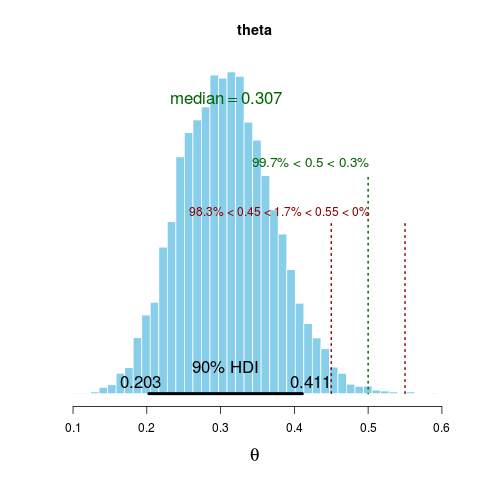

        ESS      mean    median      mode hdiMass    hdiLow   hdiHigh compVal
theta 10002 0.3087411 0.3070736 0.3143869     0.9 0.2027821 0.4109062     0.5
      pGtCompVal ROPElow ROPEhigh   pLtROPE    pInROPE   pGtROPE
theta 0.00329934    0.45     0.55 0.9828034 0.01669666 0.0004999

In [25]:
# Re-plot with different annotations:
plotPost( codaSamples[,"theta"] , main="theta" , xlab=bquote(theta) , 
          cenTend="median" , compVal=0.5 , ROPE=c(0.45,0.55) , credMass=0.90 )

#  8.3. Simplified Scripts for Frequently Used Analyses

In [26]:
# Example for Jags-Ydich-Xnom1subj-MbernBeta.R 
# Optional generic preliminaries:
graphics.off() # This closes all of R's graphics windows.

In [27]:
# Load The data 
myData = read.csv("z15N50.csv")

In [28]:
# Load the functions genMCMC, smryMCMC, and plotMCMC:
source("Jags-Ydich-Xnom1subj-MbernBeta.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



In [29]:
# Generate the MCMC chain:
mcmcCoda = genMCMC( data=myData , numSavedSteps=10000)# , saveName=fileNameRoot )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 53

Initializing model

Burning in the MCMC chain...
Sampling final MCMC chain...


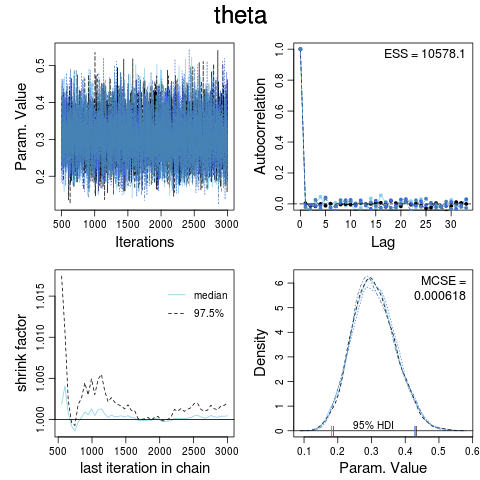

In [30]:
# Display diagnostics of chain, for specified parameter
diagMCMC( mcmcCoda , parName="theta")

In [31]:
graphics.off() 

In [32]:
# Display numerical summary statstics of chain
smryMCMC(mcmcCoda)

           Mean   Median      Mode   ESS HDImass    HDIlow   HDIhigh CompVal
theta 0.3073919 0.303801 0.2906717 10000    0.95 0.1830357 0.4290744      NA
      PcntGtCompVal ROPElow ROPEhigh PcntLtROPE PcntInROPE PcntGtROPE
theta            NA      NA       NA         NA         NA         NA


           Mean   Median      Mode   ESS HDImass    HDIlow   HDIhigh CompVal
theta 0.3073919 0.303801 0.2906717 10000    0.95 0.1830357 0.4290744      NA
      PcntGtCompVal ROPElow ROPEhigh PcntLtROPE PcntInROPE PcntGtROPE
theta            NA      NA       NA         NA         NA         NA

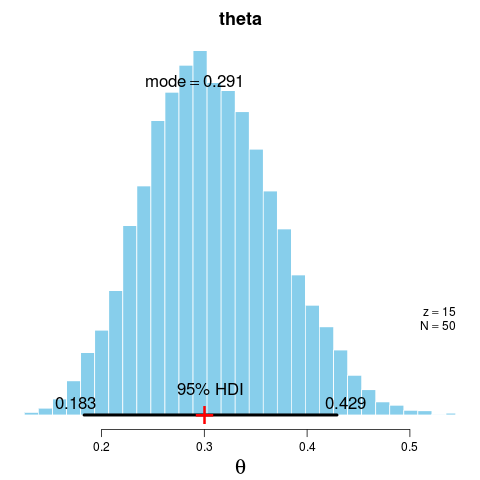

In [35]:
# Display graphical posterior information:
plotMCMC( mcmcCoda , data=myData)

In [36]:
graphics.off() 

#  8.4. Example: Difference of Biases

In [68]:
myData = read.csv("z6N8z2N7.csv")

In [69]:
str(myData)

'data.frame':	15 obs. of  2 variables:
 $ y: int  1 0 1 1 1 1 1 0 0 0 ...
 $ s: Factor w/ 2 levels "Reginald","Tony": 1 1 1 1 1 1 1 1 2 2 ...


In [70]:
myData

   y        s
1  1 Reginald
2  0 Reginald
3  1 Reginald
4  1 Reginald
5  1 Reginald
6  1 Reginald
7  1 Reginald
8  0 Reginald
9  0     Tony
10 0     Tony
11 1     Tony
12 0     Tony
13 0     Tony
14 1     Tony
15 0     Tony

In [71]:
y = myData$y

In [72]:
y

 [1] 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0

In [73]:
s = as.numeric(myData$s) # converts character to consecutive integer levels

In [74]:
s

 [1] 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2

In [75]:
Ntotal = length(y)
Nsubj = length(unique(s))
dataList = list(
    y = y,
    s = s,
    Ntotal = Ntotal,
    Nsbuj = Nsubj
)

In [ ]:
model {
    for(i in 1:Ntotal) {
        y[i] ~ dbern(theta[s[i]]) # notice nested indexing
    }
    for(s in 1:Nsubj) {
        theta[s] ~ dbeta(2,2)
    }
}

<img src="figures/fig8.5.png" />

In [49]:
# Load The data 
myData = read.csv("z6N8z2N7.csv")

In [50]:
# Load the relevant model into R's working memory:
source("Jags-Ydich-XnomSsubj-MbernBeta.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



In [52]:
# Generate the MCMC chain:
mcmcCoda = genMCMC( data=myData , numSavedSteps=50000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 35

Initializing model

Burning in the MCMC chain...
Sampling final MCMC chain...


<img src="figures/fig8.6.png" />

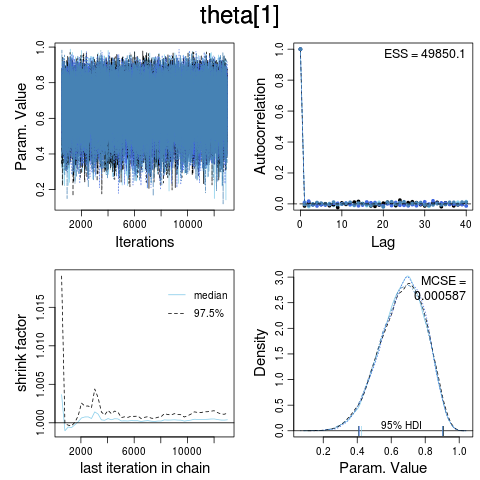

In [53]:
# Display diagnostics of chain, for specified parameters:
diagMCMC( codaObject=mcmcCoda , parName="theta[1]")

In [78]:
graphics.off()

In [55]:
# Get summary statistics of chain:
summaryInfo = smryMCMC( mcmcCoda , compVal=NULL , compValDiff=0.0)

                       Mean    Median      Mode     ESS HDImass      HDIlow
theta[1]          0.6668464 0.6763674 0.6979505 50000.0    0.95  0.41476292
theta[2]          0.3632431 0.3540373 0.3225716 51625.3    0.95  0.10866227
theta[1]-theta[2] 0.3036033 0.3107808 0.3570524 50000.0    0.95 -0.06486128
                    HDIhigh CompVal PcntGtCompVal ROPElow ROPEhigh PcntLtROPE
theta[1]          0.9074376      NA            NA      NA       NA         NA
theta[2]          0.6345419      NA            NA      NA       NA         NA
theta[1]-theta[2] 0.6716638       0          93.7      NA       NA         NA
                  PcntInROPE PcntGtROPE
theta[1]                  NA         NA
theta[2]                  NA         NA
theta[1]-theta[2]         NA         NA


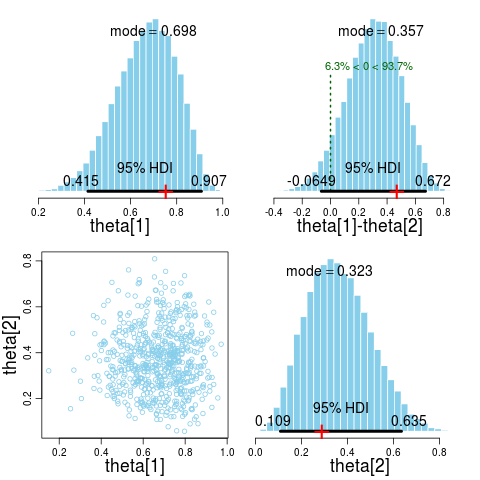

In [56]:
# Display posterior information:
plotMCMC( mcmcCoda , data=myData , compVal=NULL , compValDiff=0.0)

In [57]:
graphics.off()

#  8.5. Sampling from the Prior Distribution in JAGS

In [58]:
# To run JAGS without the data included
dataList = list(
#  y = y,
    s = s,
    Ntotal = Ntotal,
    Nsubj = Nsubj
)

<img src="figures/fig8.7.png" />

#  8.6. Probability Distributions Available in JAGS

* 8.6.1 Defining new likelihood functions

## 8.6.1 Defining new likelihood functions

In [ ]:
spy[i] <- pdf(y[i], parameters) / C # where pdf is a formula 
l ~ dbern(spy[i])

In [ ]:
data {
    C <- 10000 # JAGS does not warn if too small !
    for (i in 1:N) {
        ones[i] <- l
    }
}

In [ ]:
model {
    for(i in 1:N) {
        spy[i] <- pdf(y[i], parameters) /C 
        ones[i] <- dbern(spy[i])
    }
    parameters ~ dprior ...
}

In [ ]:
spy[i] <- (exp(-0.5*((y[i]-mu)/sigma)^2)/(sigma*(2*3.1415926)^0.5))/C

#  8.7. Faster Sampling with Parallel Processing in RunJAGS

In [60]:
#install.packages("runjags")
library("runjags")

In [61]:
nChains=3
nAdaptSteps=1000
nBurninSteps=500
nUseSteps=1000 # total number of used steps
nThinSteps=2

### rjags

In [62]:
library(rjags)

In [ ]:
jagsModel = jags.model( file="model.txt",
                                    data=dataList,
                                    inits=initList,
                                    n.chains=nChains,
                                    n.adapt=nAdaptSteps)                

In [ ]:
update(jagsModel, n.iter=nBuninSteps)

In [ ]:
codaSamples = coda.samples(jagsModel, 
                                             variable.names = c("theta"),
                                             n.iter=ceiling(nUseSteps*nThinSteps/nChains),
                                             thin=nThinSteps)

### runjags

In [64]:
library(runjags)

In [ ]:
runJagsOut <- run.jags(method="parallel",
                                  model="model.txt",
                                  monitor=c("theta"),
                                  data=dataList,
                                  inits=initList,
                                  n.chains=nChains,
                                  adapt=nAdaptSteps,
                                  burnin=nBuninSteps,
                                  sample=ceiling(nUseSteps/nChains),
                                  thin=nThinSteps,
                                  summarise=FALSE,
                                  plot=FALSE)

In [ ]:
codaSamples = as.mcmc.list(runJagsOut)

#  8.8. Tips for Expanding JAGS Models

# 참고자료

* [1] Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan - http://www.amazon.com/Doing-Bayesian-Analysis-Second-Edition/dp/0124058884